## Interpreting ML Models: Understanding Key Features

<img src="understanding-features.webp" alt="understanding-features" width="350">

In [1]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

# packages
import pandas as pd
import numpy as np
import os, yaml, requests, random
np.random.seed(42)
import joblib
import psycopg2
import json
from sqlalchemy import create_engine

# pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# shap
import shap

# dice
import dice_ml
from dice_ml.utils import helpers

Understanding how a machine learning algorithm makes predictions is important for several reasons:

1. **Transparency and Trust:** Knowing the decision-making process helps build trust in the model. When we understand how the algorithm arrives at its conclusions, we can have more confidence in its predictions.

2. **Improving Models:** By understanding the factors that influence the model's decisions, we can make informed adjustments to improve its performance. This could involve tweaking the algorithm, adjusting the data, or refining the features used.

3. **Identifying Bias:** Insight into the prediction process allows us to detect and address any biases in the model. This ensures that the algorithm makes fair and unbiased decisions.

4. **Compliance:** In many industries, there are regulations that require explanations for automated decisions. Understanding how predictions are made helps meet these legal and ethical standards.

5. **Debugging and Maintenance:** When the model's predictions are clear, it’s easier to identify and fix errors or unexpected behavior, ensuring the model continues to perform well over time.

For our current process we'll use **SHAP**, the SHAP (SHapley Additive exPlanations) algorithm is a tool used to explain the predictions made by machine learning models. Here’s an easy explanation:

1. **Breaks Down Predictions:** SHAP explains the prediction of a model by breaking it down into contributions from each feature (input variable). It tells us how much each feature contributed to the final prediction.

2. **Fair Distribution:** It’s based on the concept of Shapley values from **cooperative game theory,** which fairly distributes the “payout” (prediction) among all features, considering all possible combinations of features. This ensures a balanced and fair explanation.

3. **Consistent:** SHAP provides consistent and reliable explanations, meaning similar contributions from features will always result in similar Shapley values, making it easier to interpret the results.

4. **Visual and Intuitive:** SHAP values can be visualized in plots, making it intuitive to see which features are driving the predictions and how they are doing so. This helps in understanding the model’s behavior and making it more transparent.

In summary, SHAP helps us understand how each feature affects a model’s predictions, ensuring the explanations are fair, consistent, and easy to interpret.

### `base model - explainer`

*load Decision Tree Classifier*

In [2]:
joblib_file = "models/DT-baseline.pkl"
model = joblib.load(joblib_file)
print("Model loaded")

Model loaded


In [3]:
model

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=3,
                       random_state=42)

*load train/test*

In [4]:
### train
X_train=pd.read_excel('models/X-train.xlsx')
y_train=pd.read_excel('models/y-train.xlsx')

### test
X_test=pd.read_excel('models/X-test.xlsx')
y_test=pd.read_excel('models/y-test.xlsx')

In [5]:
X_train.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,cuisine-encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,client-type-encode
0,51,45.145165,1.292334,15.143859,0,96,1,0.02534,5.0152,2.664325,197.917311,0.335448,2


In [6]:
X_test.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,cuisine-encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,client-type-encode
0,45,46.473441,4.404506,32.219891,0,19,2,0.097878,6.579109,15.5821,67.217503,0.693297,2


*SHAP*

In [7]:
explainer = shap.TreeExplainer(model)
explanation = explainer(X_test)
shap_values = explanation.values

In [8]:
shap_values_transposed = shap_values.T

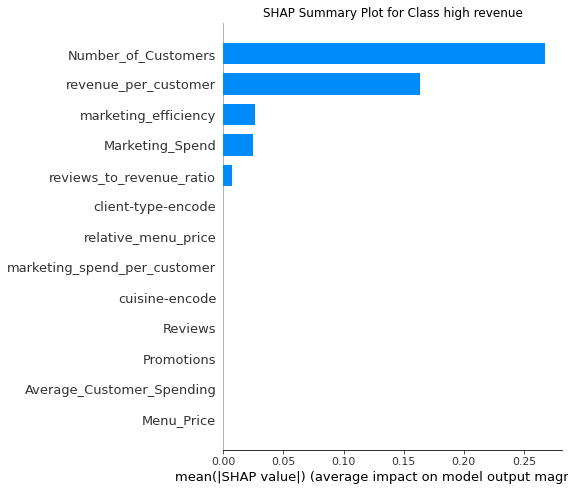

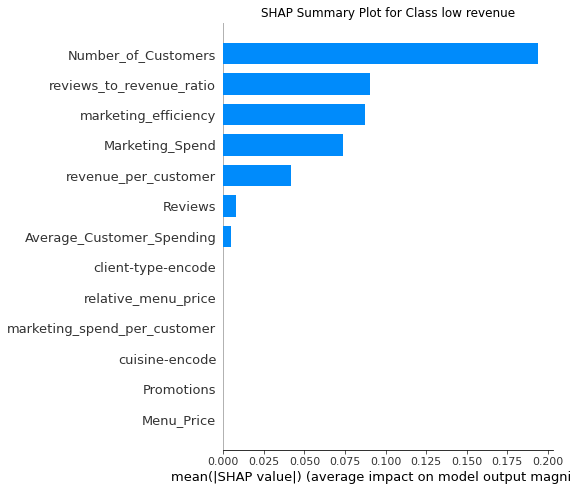

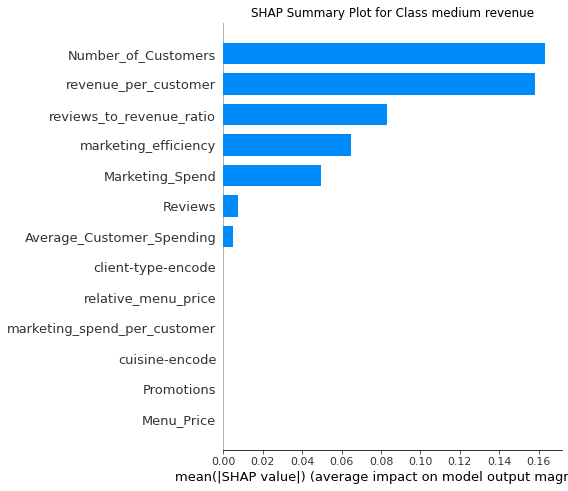

In [9]:
revenue_dict={0:'high revenue', 
              1:'low revenue',
              2:'medium revenue'}

for class_index in range(shap_values_transposed.shape[0]):
    
    shap.summary_plot(shap_values_transposed[class_index].T, 
                      feature_names=X_test.columns, 
                      plot_type="bar", 
                      show=False)    
    plt.title(f'SHAP Summary Plot for Class {revenue_dict[class_index]}')
    plt.show()

As we can see across all cases, the most critical factor for predicting any class is the number of customers. Following this, revenue per customer is particularly important for high and medium revenue sites. In contrast, for low revenue sites, customer reviews play a significant role. However, a consistent factor across all classes, alongside the number of customers, is marketing spend. 

This highlights the significant impact of marketing efforts on site revenue, regardless of the revenue class. By focusing on these key factors—number of customers, revenue per customer, customer reviews, and marketing spend—we can develop more targeted and effective strategies to enhance revenue across different segments. Understanding these drivers enables us to prioritize actions that will yield the highest returns and ensure sustainable growth.

### `best model - explainer`

We have already identified the most important features for our baseline model. Now, we turn our attention to the best-performing model in our case, which is the AdaBoost algorithm. While we observed some improvement in specific classes with the Random Forest model, overall performance, including the confusion matrix, indicates that AdaBoost is superior.

To gain a deeper understanding of AdaBoost's predictions, we need to delve into an explainer algorithm. This will help us identify the most critical variables influencing the prediction of each class. By doing so, we can further refine our model and enhance its accuracy, ensuring we leverage the most impactful features for optimal predictive performance.

*load AdaBoost Classifier*

In [10]:
joblib_file = "models/ABC.pkl"
model = joblib.load(joblib_file)
print("Model loaded")

Model loaded


In [11]:
model

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20,
                                                    random_state=42),
                   learning_rate=0.1, n_estimators=100, random_state=42)

*load train/test*

In [12]:
### train
X_train=pd.read_excel('models/X-train.xlsx')
y_train=pd.read_excel('models/y-train.xlsx')

### test
X_test=pd.read_excel('models/X-test.xlsx')
y_test=pd.read_excel('models/y-test.xlsx')

`SHAP`

In [13]:
def model_predict(X):
    return model.predict_proba(X)

explainer = shap.KernelExplainer(model_predict, shap.sample(X_train, 100))

In [14]:
shap_values = explainer.shap_values(X_test)

  0%|          | 0/200 [00:00<?, ?it/s]

In [15]:
shap_values_transposed = shap_values.T

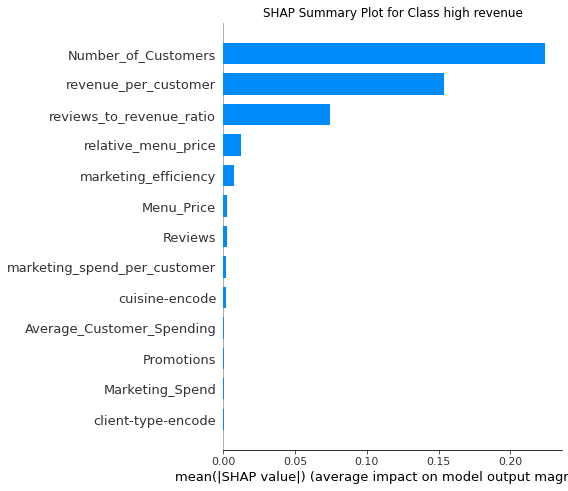

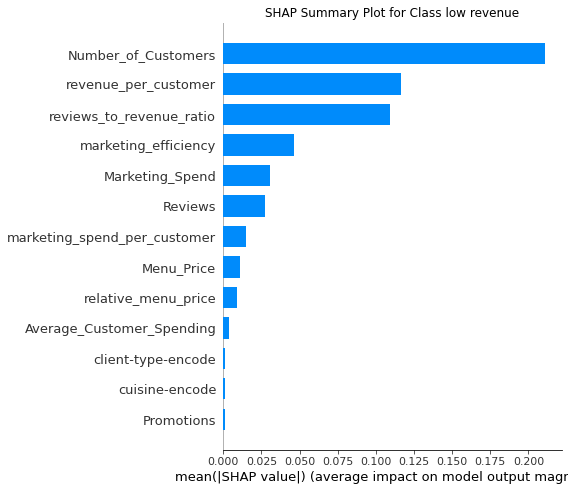

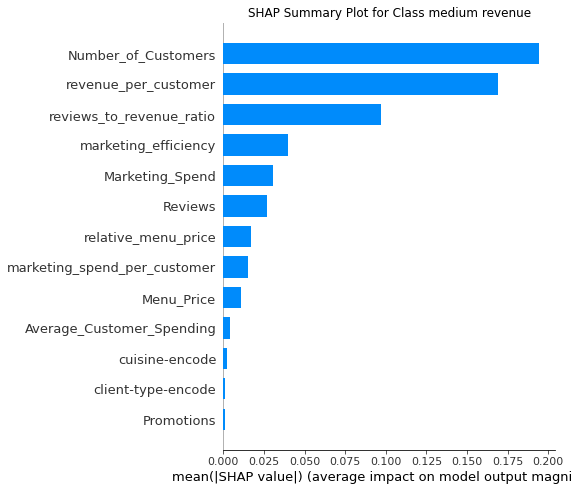

In [16]:
revenue_dict={0:'high revenue', 
              1:'low revenue',
              2:'medium revenue'}

for class_index in range(shap_values_transposed.shape[0]):
    
    shap.summary_plot(shap_values_transposed[class_index].T, 
                      feature_names=X_test.columns, 
                      plot_type="bar", 
                      show=False)
    
    plt.title(f'SHAP Summary Plot for Class {revenue_dict[class_index]}')
    plt.savefig(f'img/SHAP-summary-plot-{revenue_dict[class_index]}.png')
    plt.show()

**load data**

In [17]:
data = pd.concat([pd.read_excel('models/df-train.xlsx'),
                  pd.read_excel('models/df-test.xlsx')], ignore_index=True)
data['monthly-revenue']=data['revenue_per_customer']*data['Number_of_Customers']
data.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,cuisine-encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,client-type-encode,clf-revenue,monthly-revenue
0,51,45.145165,1.292334,15.143859,0,96,1,0.02534,5.0152,2.664325,197.917311,0.335448,2,medium revenue,255.775191


### Insights

**High Revenue:**

Analyzing the SHAP values for the AdaBoost model reveals that the primary factors for classifying a site as high revenue are the number of customers and the revenue per customer. This is intuitive, as more customers spending more money leads to higher profitability.

However, we also consider additional features such as marketing efficiency, marketing spend, and the reviews-to-revenue ratio:

- **Reviews to Revenue Ratio:** This metric shows the relationship between the number of reviews and monthly revenue. A high ratio may indicate a significant influence of reviews on revenue. With the highest ratio among all classification sites, it appears that the influence of reviews on revenue is substantial.

- **Marketing Efficiency and Marketing Spend:** We assess marketing efficiency by comparing marketing expenses with monthly revenue. A higher value suggests greater efficiency in converting marketing spend into revenue. For high revenue sites, marketing efficiency is not the best, and marketing spend is the highest among all revenue types, indicating an opportunity for improvement in this metric.

- **Relative Menu Price:** This compares the menu price with the average customer spending. A value greater than 1 indicates that customers are willing to pay more than the average menu price, suggesting a less price-sensitive clientele. However, for high revenue sites, customers do not spend significantly more than the average menu price.

<img src="img/shap-high-revenue-shortcut.png" alt="shap-high-revenue-shortcut" width="500">

**Low Revenue:**

For low revenue sites, the key factors are similar: the number of customers and the revenue per customer. Additionally, we consider the reviews-to-revenue ratio, marketing efficiency, and marketing spend per customer:

- **Reviews to Revenue Ratio:** This metric shows the relationship between the number of reviews and monthly revenue. A high ratio may indicate a significant influence of reviews on revenue. Despite a high number of reviews, low revenue sites show that reviews significantly impact revenue.

- **Marketing Efficiency and Marketing Spend:** We assess marketing efficiency by comparing marketing expenses with monthly revenue. Low revenue sites spend less on marketing but have the highest marketing efficiency, suggesting that their marketing spend is well converted into revenue. Increasing marketing spend could potentially improve their revenue.

- **Marketing Spend per Customer:** This metric reveals how efficiently marketing resources are used to attract customers. For low revenue sites, marketing spend per customer is the highest, yet the number of customers is the lowest. This inefficiency indicates a need for deeper analysis to improve customer acquisition.

<img src="img/shap-low-revenue-shortcut.png" alt="shap-low-revenue-shortcut" width="500">

**Medium Revenue:**

For medium revenue sites, the key factors remain the number of customers and the revenue per customer. Additionally, we consider marketing efficiency, marketing spend, and the reviews-to-revenue ratio:

- **Reviews to Revenue Ratio:** This metric shows the relationship between the number of reviews and monthly revenue. A high ratio may indicate a significant influence of reviews on revenue.

- **Marketing Efficiency and Marketing Spend:** We assess marketing efficiency by comparing marketing expenses with monthly revenue. A higher value suggests greater efficiency in converting marketing spend into revenue.

- **Relative Menu Price:** This compares the menu price with the average customer spending. A value greater than 1 indicates that customers are willing to pay more than the average menu price, suggesting a less price-sensitive clientele.

The medium revenue segment shares similarities with the high revenue segment. The key features for the model are reviews, marketing, and to a lesser extent, the menu price. Notably, despite higher menu prices (on average) in medium revenue sites compared to low revenue sites, the number of customers remains higher. This insight helps us understand how the AdaBoost model makes decisions and highlights areas for potential optimization across different revenue segments.

<img src="img/shap-medium-revenue-shortcut.png" alt="shap-medium-revenue-shortcut" width="500">

### `More insights:`

As we can see in the next table, the classification of the sites may contain different types of clients, from economic to premium. It's important to remember that the client type was determined based on the average menu price of each cluster.

*`High Revenue`*
- The table shows that the average customer spending and the number of clients are lower for premium clients than for economic clients, but the revenue per customer is higher for the premium segment. Interestingly, the standard clients have the highest revenue per customer among the high revenue sites. Based on this, we can consider two strategies:
  1. Increase the number of visits to sites with standard clients while maintaining the average revenue per customer.
  2. Increase the revenue per customer for sites with economic clients.

*`Low Revenue`*
- For the low revenue sites, the SHAP values highlighted the importance of the number of customers and the revenue per customer. The data shows that both these metrics are lower compared to other clusters. To address this, we need to identify the causal variables that can increase revenue. Two potential actions are:
  1. Increase the number of customers through specific actions. Before developing an action plan, it is crucial to understand the causal variables that drive customer visits.
  2. Increase the menu price while maintaining the current range of customer visits. This requires an understanding of price sensitivity.

*`Medium Revenue`*
- For medium revenue sites, the situation is similar to the other segments. Economic clients spend more on average, but the revenue is slightly higher for premium clients. Although there are more economic clients, we need to consider solutions similar to those above:
  1. Increase the number of clients without decreasing revenue or prices.
  2. Increase the prices without decreasing the number of customers.

By understanding these dynamics, we can tailor our strategies to maximize revenue across different client types and site classifications.

In [18]:
condition_list=[data['client-type-encode']==0,
                data['client-type-encode']==1,
                data['client-type-encode']==2]

choice_list=['standard', 'economic', 'premium']

data['client-type']=np.select(condition_list, choice_list, 'no data')
data.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,cuisine-encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,client-type-encode,clf-revenue,monthly-revenue,client-type
0,51,45.145165,1.292334,15.143859,0,96,1,0.02534,5.0152,2.664325,197.917311,0.335448,2,medium revenue,255.775191,premium


In [19]:
cols= ['Number_of_Customers','Average_Customer_Spending', 'revenue_per_customer',
       'clf-revenue', 'client-type', 'monthly-revenue']

data[cols].groupby(by=['clf-revenue', 'client-type'], as_index=True).agg('mean')

Number_of_Customers  Average_Customer_Spending  \
clf-revenue    client-type                                                   
high revenue   economic               82.750000                  39.362149   
               premium                78.539535                  27.469892   
               standard               33.750000                  35.982112   
low revenue    economic               34.327869                  33.780046   
               premium                39.687500                  20.747534   
               standard               17.687500                  27.483517   
medium revenue economic               63.533784                  36.760587   
               premium                62.183036                  24.687426   
               standard               27.291339                  28.863863   

                            revenue_per_customer  monthly-revenue  
clf-revenue    client-type                                         
high revenue   economic                 4.742285       387.382660  
               premium                  5.354601       404.251373  
               standard                11.221644       369.465261  
low revenue    economic                 4.185148       128.846336  
               premium                  4.446796       167.913557  
               standard                 8.453181       134.991999  
medium revenue economic                 4.410048       262.249386  
               premium                  4.915345       285.398966  
               standard                10.409872       249.360391

### `exploring hypotheticals`

<img src="what-if.webp" alt="what-if" width="450">

In [20]:
test=X_test.merge(y_test, left_index=True, right_index=True)
test.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,cuisine-encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,client-type-encode,clf-revenue
0,45,46.473441,4.404506,32.219891,0,19,2,0.097878,6.579109,15.5821,67.217503,0.693297,2,medium revenue


#### *`DiCE (Diverse Counterfactual Explanations)`*

The next question we need to address is:

- What adjustments do we need to make to improve revenue? While SHAP gives us insights into the most important features for the model, we need a strategy to improve revenue. To do this, we must know which features to adjust and by what proportion. This is where DiCE (Diverse Counterfactual Explanations) comes in.

DiCE (Diverse Counterfactual Explanations) is an algorithm that helps explain machine learning model predictions by showing alternative scenarios. Here's an easy explanation:

1. **What-If Scenarios:** DiCE creates "what-if" scenarios by tweaking the input features slightly to see how these changes affect the prediction. This helps us understand what needs to change for a different outcome.

2. **Diverse Explanations:** Instead of providing just one alternative, DiCE offers multiple diverse counterfactual explanations. This shows various ways to achieve a different prediction, giving a broader understanding of the model's behavior.

3. **Actionable Insights:** These counterfactual explanations can suggest actionable changes. For example, if a loan application is denied, DiCE might show what changes (like increasing income or reducing debt) could lead to approval.

4. **Model Transparency:** By showing how different inputs lead to different outputs, DiCE makes the model's decision-making process more transparent and easier to trust.

In summary, DiCE helps us understand and trust machine learning models by providing multiple alternative scenarios that explain how different inputs can change the predictions. This approach is particularly useful for identifying which features to adjust and by how much to achieve the desired increase in revenue. By leveraging DiCE, we can formulate targeted and effective strategies for revenue enhancement, ensuring our model not only performs well but also provides actionable insights for continuous improvement.

In [21]:
d=dice_ml.Data(dataframe=test,
               continuous_features=list(test.columns[:-1]),
               outcome_name='clf-revenue')

m=dice_ml.Model(model=model, 
                backend='sklearn')

exp=dice_ml.Dice(d, 
                 m, 
                 method='random')

In [22]:
dc_data=test[test['clf-revenue'] != 'high revenue'].reset_index(drop=True)

In [23]:
def json_pandas(dice):
    return pd.json_normalize(json.loads(dice.to_json()))    

*create the scenarios*

In [39]:
clf_dict={'high revenue':0,
          'low revenue':1,
          'medium revenue':2}

features_vary=['Number_of_Customers', 'Menu_Price', 'Marketing_Spend', 'Average_Customer_Spending', 'Reviews',
               'revenue_per_customer', 'relative_menu_price', 'reviews_to_revenue_ratio']

dice_df=pd.DataFrame()

for idx in range(len(dc_data)):
    
    buffer_df=pd.DataFrame()
    query_instance = dc_data.iloc[idx]
    current_class = query_instance['clf-revenue']
    print(idx)
    
    if current_class == 'low revenue':
        desired_class='medium revenue'
        print(current_class, '<==>', desired_class, '-', clf_dict[desired_class])
        cf=exp.generate_counterfactuals(pd.DataFrame(dc_data.drop(columns=['clf-revenue']).iloc[idx]).T, 
                                        total_CFs=3, 
                                        desired_class=clf_dict[desired_class],
                                        features_to_vary=features_vary)
        buffer_df=pd.concat([buffer_df, json_pandas(cf)], ignore_index=True)
        
    else:
        desired_class='high revenue'
        print(current_class, '<==>', desired_class, '-', clf_dict[desired_class])
        cf=exp.generate_counterfactuals(pd.DataFrame(dc_data.drop(columns=['clf-revenue']).iloc[idx]).T, 
                                        total_CFs=3, 
                                        desired_class=clf_dict[desired_class],
                                        features_to_vary=features_vary)
        buffer_df=pd.concat([buffer_df, json_pandas(cf)], ignore_index=True)
    
    dice_df=pd.concat([dice_df, buffer_df], ignore_index=True)

0
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


1
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.91it/s]


2
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.71it/s]


3
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.85it/s]


4
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  6.98it/s]


5
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  8.54it/s]


6
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:20<00:00, 20.52s/it]


7
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:22<00:00, 22.86s/it]


8
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.10it/s]


9
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


10
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


11
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.62it/s]


12
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


13
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


14
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.98it/s]


15
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.48it/s]


16
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:23<00:00, 23.65s/it]


17
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  7.76it/s]


18
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.79it/s]


19
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


20
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.46it/s]


21
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


22
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


23
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


24
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


25
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


26
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]


27
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


28
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]

29
low revenue <==> medium revenue - 2



100%|████████████████████████████| 1/1 [00:00<00:00,  6.43it/s]


30
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  5.63it/s]


31
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]


32
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  5.91it/s]

33
low revenue <==> medium revenue - 2



100%|████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


34
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:19<00:00, 19.88s/it]


35
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  9.22it/s]


36
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


37
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.53it/s]


38
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


39
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.82it/s]


40
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.25it/s]


41
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.74it/s]


42
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


43
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


44
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


45
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:19<00:00, 19.58s/it]


46
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


47
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.68it/s]


48
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


49
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]


50
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


51
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  7.29it/s]


52
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


53
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


54
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  8.51it/s]


55
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


56
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:24<00:00, 24.73s/it]


57
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.64it/s]


58
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:22<00:00, 22.23s/it]


59
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:18<00:00, 18.69s/it]


60
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  4.41it/s]


61
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


62
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


63
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


64
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.40it/s]


65
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


66
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.89it/s]


67
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  7.52it/s]


68
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]


69
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:18<00:00, 18.79s/it]


70
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.52it/s]


71
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  8.00it/s]


72
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


73
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:19<00:00, 19.26s/it]


74
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


75
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.95it/s]


76
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:18<00:00, 18.50s/it]


77
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  7.41it/s]


78
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


79
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


80
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.00it/s]


81
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:19<00:00, 19.61s/it]


82
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  6.67it/s]


83
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  5.01it/s]


84
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


85
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  4.91it/s]


86
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


87
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


88
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]


89
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  5.98it/s]

90
medium revenue <==> high revenue - 0



100%|████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


91
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


92
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.60it/s]


93
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.57it/s]


94
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.41it/s]


95
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.62it/s]


96
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.15it/s]


97
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.14it/s]


98
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  6.27it/s]


99
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]

100
medium revenue <==> high revenue - 0



100%|████████████████████████████| 1/1 [00:00<00:00,  6.85it/s]


101
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


102
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


103
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.75it/s]


104
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  6.41it/s]

105
medium revenue <==> high revenue - 0



100%|████████████████████████████| 1/1 [00:00<00:00,  6.75it/s]


106
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.52it/s]


107
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:18<00:00, 18.97s/it]


108
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.07it/s]


109
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]


110
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]


111
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]


112
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.14it/s]


113
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.58it/s]


114
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]


115
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  6.90it/s]


116
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.05it/s]


117
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.41it/s]


118
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:24<00:00, 24.88s/it]


119
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.33it/s]


120
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


121
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.59it/s]


122
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.74it/s]


123
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


124
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


125
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.36it/s]


126
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.57it/s]


127
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


128
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.74it/s]


129
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  8.11it/s]


130
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


131
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


132
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]


133
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:28<00:00, 28.66s/it]


134
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


135
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:22<00:00, 22.94s/it]


136
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.25it/s]


137
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:24<00:00, 24.48s/it]


138
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


139
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]

140
low revenue 

<==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  6.28it/s]


141
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


142
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:23<00:00, 23.03s/it]


143
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


144
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


145
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  5.90it/s]


146
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  6.33it/s]


147
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:47<00:00, 47.53s/it]


148
low revenue <==> medium revenue - 2


100%|████████████████████████████| 1/1 [00:00<00:00,  7.80it/s]


149
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  8.68it/s]


150
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


151
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.35it/s]


152
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


153
medium revenue <==> high revenue - 0


100%|████████████████████████████| 1/1 [00:18<00:00, 18.53s/it]


In [41]:
org_data=pd.DataFrame(dice_df.explode('test_data')['test_data'].to_list(), 
                      columns=['original-scenario'])

scenario_data=pd.DataFrame(dice_df.explode('cfs_list')['cfs_list'].to_list(), 
                           columns=['scenario-0', 'scenario-1', 'scenario-2'])

scenarios=pd.concat([org_data, scenario_data, dice_df['feature_names_including_target']], axis=1)

scenarios.to_excel('output/scenarios.xlsx', index=False)
scenarios.head(1)

,original-scenario,scenario-0,scenario-1,scenario-2,feature_names_including_target
0,"[45.0, 46.47344207763672, 4.404506206512451, 3...","[75.0, 46.47344139839645, 4.404506027546303, 1...","[45.0, 46.47344139839645, 4.404506027546303, 3...","[45.0, 46.47344139839645, 4.404506027546303, 3...","[Number_of_Customers, Menu_Price, Marketing_Sp..."


In [47]:
scenarios.tail(1)

,original-scenario,scenario-0,scenario-1,scenario-2,feature_names_including_target
153,"[71.0, 13.092843055725098, 19.41499900817871, ...","[88.0, 13.09284261955149, 19.4149991534134, 10...","[71.0, 13.09284261955149, 19.4149991534134, 11...","[71.0, 13.09284261955149, 19.4149991534134, 10...","[Number_of_Customers, Menu_Price, Marketing_Sp..."


In [42]:
def add_suffix(df, suffix):
    return df.rename(columns=lambda col_name: f"{col_name}-{suffix}")

In [44]:
final_original=pd.DataFrame()

for idx in range(len(scenarios)):
    
    buffer_original=pd.DataFrame()
    
    buffer_original=pd.DataFrame(scenarios['original-scenario'].iloc[idx]).T
    buffer_original.columns=scenarios['feature_names_including_target'].iloc[idx]
    
    final_original=pd.concat([final_original, buffer_original], ignore_index=True)    
    
# write into excel file
final_original.to_excel(f'output/original.xlsx', index=False)

In [46]:
scenario_list=['scenario-0', 'scenario-1', 'scenario-2']

for sc in scenario_list:
        
    final_scenario=pd.DataFrame()
    
    for idx in range(len(scenarios)):
        
        buffer_scenario=pd.DataFrame()
        
        # get the df with the cf's in columns
        buffer_scenario=pd.DataFrame(scenarios[sc].iloc[idx]).T
        
        # set the column name
        buffer_scenario.columns=scenarios['feature_names_including_target'].iloc[idx]
        
        # append each scenario into a df
        final_scenario=pd.concat([final_scenario, buffer_scenario], ignore_index=True)
        
    # add a suffix
    final_scenario=add_suffix(final_scenario, '--dice')
                        
    # write into excel file
    final_scenario.to_excel(f'output/{sc}.xlsx', index=False)